In [3]:
import os
import pickle
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

plt.ioff()
plt.rcParams['figure.dpi'] = 150
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12

tfkl = tf.keras.layers
tfpl = tfp.layers
tf.keras.backend.set_floatx("float64")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [4]:
def load_mdn(DT, N_C, user):
    """
    Loads MDN model.
    """

    model = tf.keras.Sequential(
        [tfkl.Dense(256, activation='tanh'),
         tfkl.Dense(256, activation='tanh'),
         tfkl.Dense(256, activation='tanh'),
         tfkl.Dense(256, activation='tanh'),
         tfkl.Dense(512, activation='tanh'),
         tfkl.Dense(512, activation='tanh'),
         tfkl.Dense(N_C * 15, activation=None),
         tfpl.MixtureSameFamily(N_C, tfpl.MultivariateNormalTriL(4))])

    model.load_weights(
        f"../models/{user}/GDP_{DT:.0f}day_NC{N_C}/trained/weights.index").expect_partial()
    return model

In [86]:
def load_scalers(DT, N_C, user):
    """
    Loads scaler objects relating to MDN models.
    """

    with open(f"../models/{user}/GDP_{DT:.0f}day_NC{N_C}/Xscaler.pkl", "rb") as file:
        Xscaler = pickle.load(file)

    with open(f"../models/{user}/GDP_{DT:.0f}day_NC{N_C}/Yscaler.pkl", "rb") as file:
        Yscaler = pickle.load(file)
    return Xscaler, Yscaler

def given(X_1, X_0, X_scaler, Y_scaler, model):
    """
    Evaluates transition density for fixed X_0.
    """
    dx = np.abs(X_1 - X_0)
    return Y_scaler.invert_standardisation_prob(
        np.exp(
            model.log_prob(
                X_scaler.standardise(dx)))
        )

def make_position(A0: list, B0: list) -> np.array:
    if not isinstance(A0, np.ndarray):
        A0 = np.array(A0).reshape((2, 1))

    if not isinstance(B0, np.ndarray):
        B0 = np.array(B0).reshape((2, 1))

    return np.vstack([A0, B0]).reshape(4, 1) 

In [79]:
# Model parameters.
N_C = 32
DT = 4
user = "masha"

# Load our trained model.
model = load_mdn(DT, N_C, user)

# Load the model scalers.
X_scaler, Y_scaler = load_scalers(DT, N_C, user)


initial_pos = make_position([0.6, 0.6], [0.4, 0.4])
next_pos = make_position([0.5, 0.5], [0.4, 0.4])

model_at_init = model(X_scaler.standardise(initial_pos))
print(given(next_pos, initial_pos, X_scaler, Y_scaler, model_at_init))

initial_pos = make_position([0.6, 0.6], [0.4, 0.4])
next_pos = make_position([0.6, 0.6], [0.3, 0.3])

model_at_init = model(X_scaler.standardise(initial_pos))
print(given(next_pos, initial_pos, X_scaler, Y_scaler, model_at_init))

[0.00978434 0.00978434 0.00019888 0.00019888]
[0.00010994 0.00010994 0.01447777 0.01447777]


In [70]:


def plot_transition_densities(A0, B0, A1, DT, N_C, user, disc_n=20, ax=None):
    # Load our trained model.
    model = load_mdn(DT, N_C, user)

    # Load the model scalers.
    X_scaler, Y_scaler = load_scalers(DT, N_C, user)

    # Combine the initial positions to get a vector our model can understand.
    initial_position = make_position(A0, B0)

    model_at_init = model(X_scaler.standardise(initial_position))

    x = np.linspace(0, 1, disc_n)
    y = np.linspace(0, 1, disc_n)
    xx, yy = np.meshgrid(x, y, copy=True)

    B1_positions = np.vstack([xx.ravel(), yy.ravel()])
    # print(f"{B1_positions.shape = }")

    A1_positions = np.repeat(A1, disc_n**2, axis=1)
    # print(f"{A1_positions.shape = }")

    updated_positions = np.vstack([A1_positions, B1_positions])
    # print(f"{updated_positions.shape = }")

    probs = np.zeros_like(updated_positions)

    for i in range(updated_positions.shape[1]):
        p = updated_positions[:, i]
        probs[:, i] = given(p, initial_position, X_scaler, Y_scaler, model_at_init)

    x0_1_probs = probs[0, :].reshape((disc_n, disc_n))
    x0_2_probs = probs[1, :].reshape((disc_n, disc_n))
    x1_1_probs = probs[2, :].reshape((disc_n, disc_n))
    x1_2_probs = probs[3, :].reshape((disc_n, disc_n))

    # print(x0_1_probs[0, 0])
    # print(x0_2_probs[0, 0])
    # print(x1_1_probs[0, 0])
    # print(x1_2_probs[0, 0])

    # print(probs)

    if ax is None:
        _, ax = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(8, 6))
    
    # cmap=cm.RdYlBu

    # axs = axs.flatten()
    ax[0].plot_surface(xx, yy, x0_1_probs, cmap="Reds", linewidth=0.5, edgecolors='k', label="A1_x")
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")
    ax[0].plot_surface(xx, yy, x0_2_probs, cmap="Blues", linewidth=0.5, edgecolors='k', label="A1_y")
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")
    
    ax[1].plot_surface(xx, yy, x1_1_probs, cmap="Reds", linewidth=0.5, edgecolors='k', label="B1_x")
    ax[1].set_xlabel("x")
    ax[1].set_ylabel("y")
    ax[1].plot_surface(xx, yy, x1_2_probs, cmap="Blues", linewidth=0.5, edgecolors='k', label="B1_y")
    ax[1].set_xlabel("x")
    ax[1].set_ylabel("y")

    ax[1].legend()
    ax[0].legend()

    return probs

array([[0.01657341, 0.0206775 , 0.02452591, ..., 0.00496088, 0.00759172,
        0.01112874],
       [0.01657341, 0.0206775 , 0.02452591, ..., 0.00496088, 0.00759172,
        0.01112874],
       [0.01657341, 0.0206775 , 0.02452591, ..., 0.00496088, 0.00759172,
        0.01112874],
       [0.01657341, 0.0206775 , 0.02452591, ..., 0.00496088, 0.00759172,
        0.01112874]])

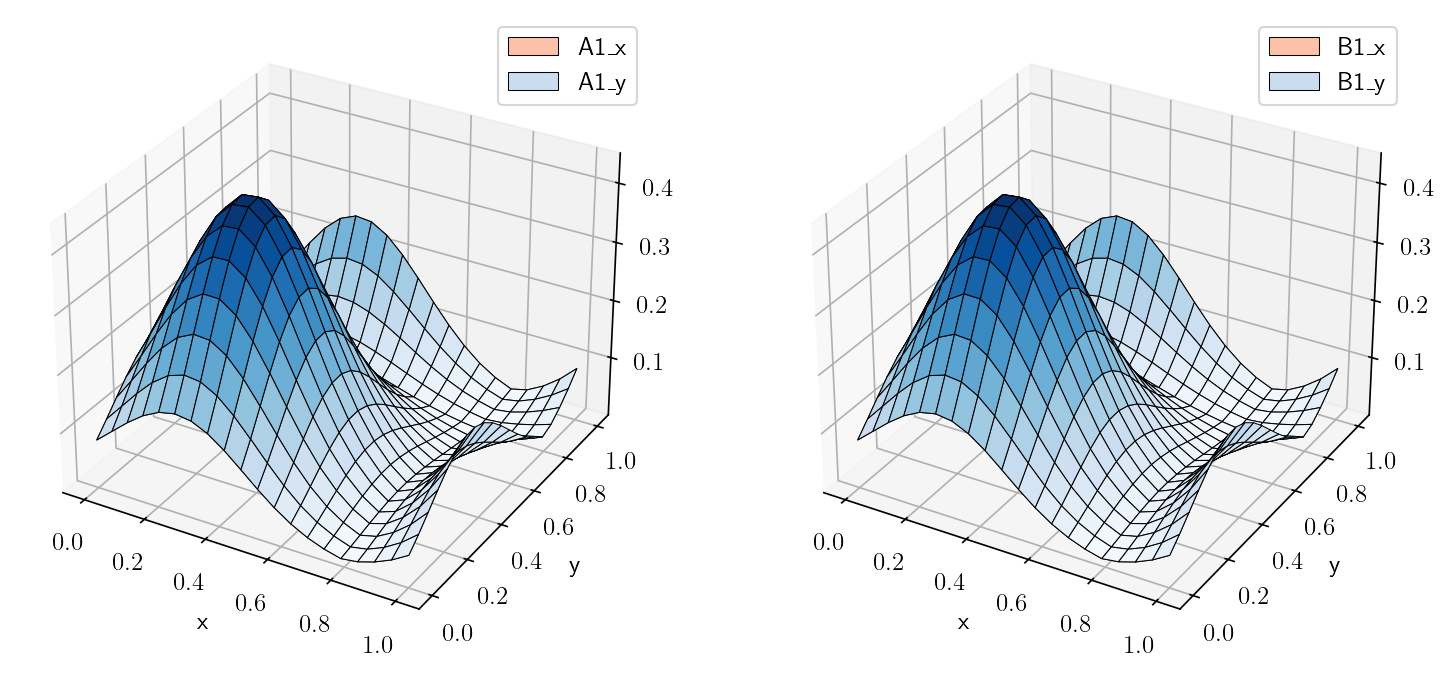

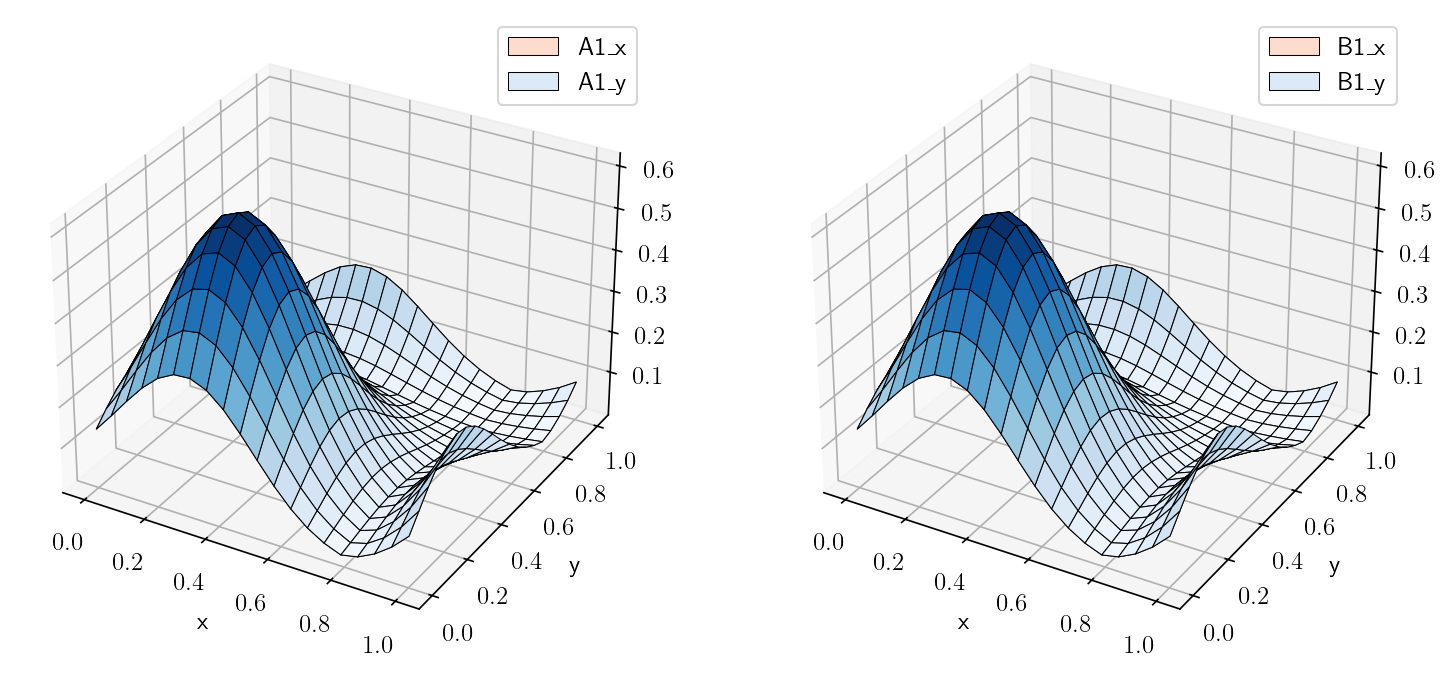

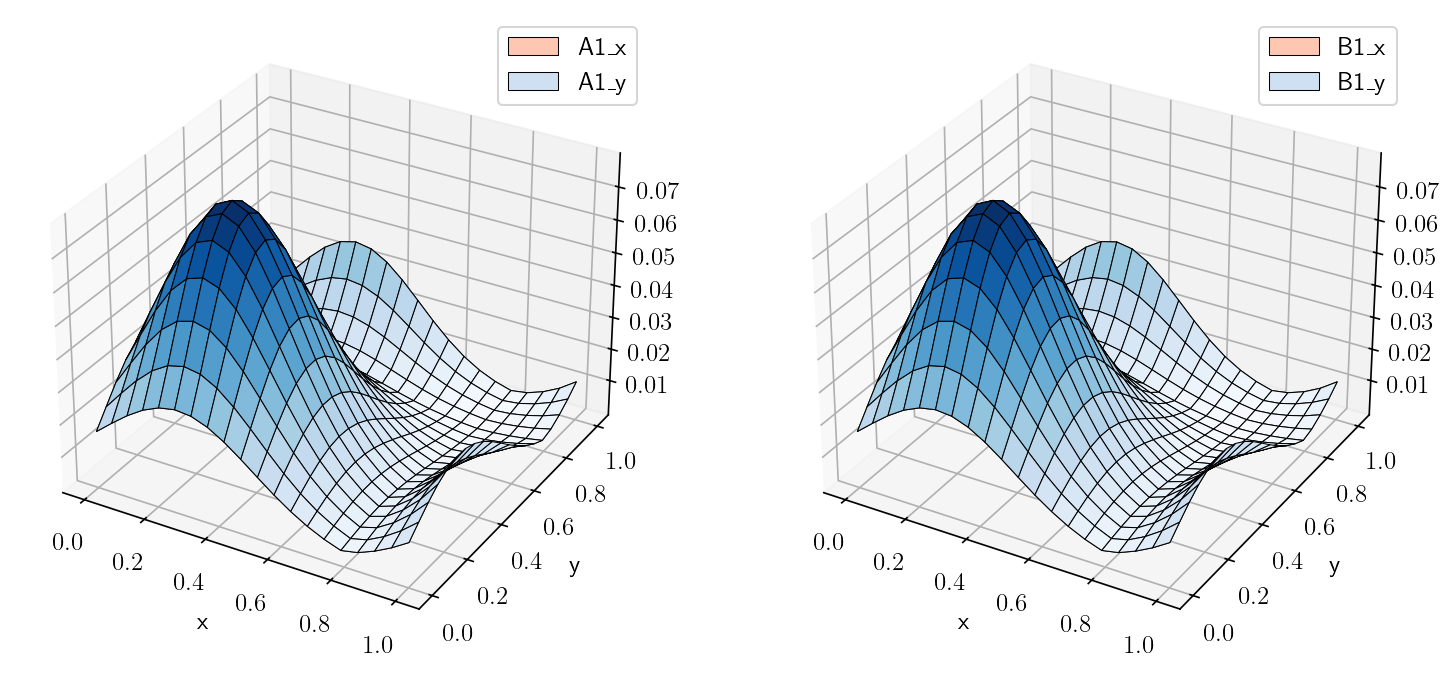

In [100]:
# Model parameters.
N_C = 32
DT = 4
user = "masha"

 # Define the initial position of the first particle
A0 = np.array([0.8, 0.8]).reshape(2, 1)
# and the second particle.
B0 = np.array([0.8, 0.8]).reshape(2, 1)

_, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(12, 6))

# Fix the position of the second point, A1.
A1 = np.array([0.6, 0.8]).reshape(2, 1)

# Given two particles that start at points A0 and B0 respectively, 
probs = plot_transition_densities(A0, B0, A1, DT, N_C, user, ax=axs)

_, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(12, 6))
A1 = np.array([0.8, 1.0]).reshape(2, 1)
plot_transition_densities(A0, B0, A1, DT, N_C, user, ax=axs)

_, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(12, 6))
A1 = np.array([0.8, 0.8]).reshape(2, 1)
plot_transition_densities(A0, B0, A1, DT, N_C, user, ax=axs)

In [28]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame()
print()

# x0_1_probs = probs[0, :].reshape((disc_n, disc_n))
#     x0_2_probs = probs[1, :].reshape((disc_n, disc_n))
#     x1_1_probs = probs[2, :].reshape((disc_n, disc_n))
#     x1_2_probs = probs[3, :].reshape((disc_n, disc_n))

df["x_a"] = probs[0, :]

print(df)

# sns.kdeplot(data=geyser, x="waiting", y="duration", hue="kind")

# g = sns.JointGrid(data=probs, x="bill_length_mm", y="bill_depth_mm", hue="species")
# g.plot(sns.scatterplot, sns.histplot)


          x_a
0    0.000996
1    0.001924
2    0.003456
3    0.005769
4    0.008952
..        ...
395  0.008950
396  0.005778
397  0.003468
398  0.001934
399  0.001003

[400 rows x 1 columns]


array([[0.71971302, 0.46125666, 0.31088926, ..., 2.01761631, 1.39857094,
        0.91448287],
       [0.71971302, 0.46125666, 0.31088926, ..., 2.01761631, 1.39857094,
        0.91448287],
       [1.13819165, 0.75595234, 0.47459083, ..., 2.85700402, 2.07464236,
        1.41712989],
       [1.13819165, 0.75595234, 0.47459083, ..., 2.85700402, 2.07464236,
        1.41712989]])

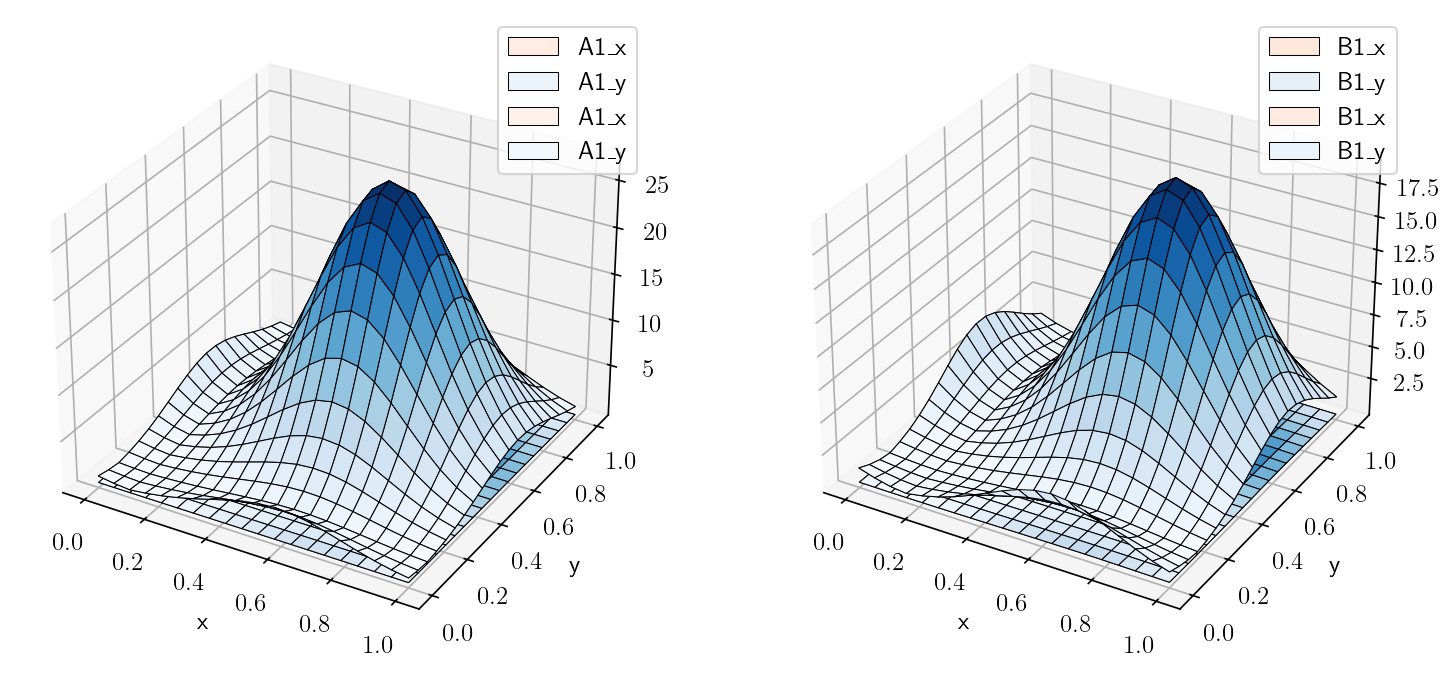

In [102]:
 # Define the initial position of the first particle
A0 = np.array([0.1, 0.1])
# and the second particle.
B0 = np.array([0.15, 0.15])

_, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(12, 6))

# Fix the position of the second point, A1.
A1 = np.array([0.1, 0.1]).reshape(2, 1)

# Given two particles that start at points A0 and B0 respectively, 
plot_transition_densities(A0, B0, A1, DT, N_C, user, ax=axs)

A1 = np.array([0.5, 0.5]).reshape(2, 1)
plot_transition_densities(A0, B0, A1, DT, N_C, user, ax=axs)

In [22]:
def plot_positions(initial_pos, next_pos):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    ax.scatter(initial_pos[0], initial_pos[1], label="Initial position of A")
    ax.scatter(initial_pos[2], initial_pos[3], label="Initial position of B")
    ax.scatter(next_pos[0], next_pos[1], label="Next position of A")
    ax.scatter(next_pos[2], next_pos[3], label="Next position of B")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend()
    plt.show()

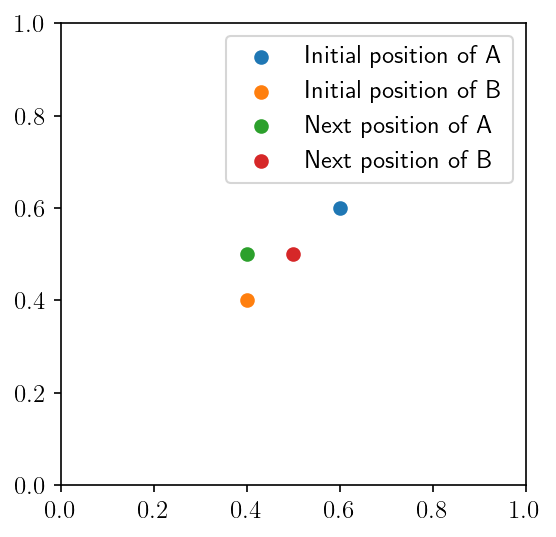

In [23]:
# Load our trained model.
model = load_mdn(DT, N_C, user)

# Load the model scalers.
X_scaler, Y_scaler = load_scalers(DT, N_C, user)


initial_pos = make_position([0.6, 0.6], [0.4, 0.4])
next_pos = make_position([0.4, 0.5], [0.5, 0.5])
plot_positions(initial_pos, next_pos)

model_at_init = model(X_scaler.standardise(initial_pos))



In [51]:

next_pos = make_position([0.4, 0.5], [0.5, 0.5])

print(given(next_pos, initial_pos, X_scaler, Y_scaler, model_at_init))

next_pos = make_position([0.4, 0.5], [0.6, 0.6])
print(given(next_pos, initial_pos, X_scaler, Y_scaler, model_at_init))

next_pos = make_position([0.4, 0.5], [0.7, 0.7])
print(given(next_pos, initial_pos, X_scaler, Y_scaler, model_at_init))


next_pos = make_position([0.4, 0.5], [0.8, 0.8])
print(given(next_pos, initial_pos, X_scaler, Y_scaler, model_at_init))

[2.12725644e-09 7.84755197e-07 1.34304362e-02 1.34304362e-02]
[2.12725644e-09 7.84755197e-07 4.02826245e-01 4.02826245e-01]
[2.12725644e-09 7.84755197e-07 4.92552359e+00 4.92552359e+00]
[2.12725644e-09 7.84755197e-07 2.29390748e+01 2.29390748e+01]
